In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

# Load Mistral-7b Model

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,AutoConfig
import torch
model_id = "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1"
config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16)
print(torch.version.cuda)

11.8


In [2]:
if torch.cuda.is_available():
    cuda_device_count = torch.cuda.device_count()
    print(f"Number of CUDA devices available: {cuda_device_count}")
    for i in range(cuda_device_count):
        device = torch.cuda.get_device_properties(i)
        print(f"CUDA device {i}: {device.name}, CUDA version: {torch.version.cuda}")

Number of CUDA devices available: 2
CUDA device 0: Tesla T4, CUDA version: 11.8
CUDA device 1: Tesla T4, CUDA version: 11.8


In [3]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

In [4]:
model_config = AutoConfig.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id,quantization_config=config,config=model_config,device_map='auto')
if torch.cuda.is_available():
    cuda_device_count = torch.cuda.device_count()
    if cuda_device_count >= 2:
        device_0 = torch.device("cuda:0") 
        device_1 = torch.device("cuda:1")
        model = torch.nn.DataParallel(model, device_ids=[0, 1])  
    else:
        model = model.to('cuda:0')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
! pip install langchain

In [5]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.llms import HuggingFacePipeline
from transformers import pipeline
text_generation_pipeline = pipeline(task='text-generation',
                                    model=model.module,
                                    tokenizer=tokenizer,
                                    temperature=0.8,
                                    repetition_penalty=1.1,
                                    return_full_text=True,
                                    max_new_tokens=1500,
                                    do_sample=True,
                                    pad_token_id = tokenizer.eos_token_id
                                   )
mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

In [6]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
template = "[INST]{question}[/INST]"
prompt = PromptTemplate(template=template,input_variables=['question'])
chain = LLMChain(llm=mistral_llm,prompt=prompt,verbose=True)

In [7]:
chain.run('What is Machine Learning')



> Entering new LLMChain chain...
Prompt after formatting:
[INST]What is Machine Learning[/INST]

> Finished chain.


' Machine learning (\n\nA subset of artificial intelligence, machine learning refers to the process of designing algorithms that can automatically learn and improve their performance from data. These algorithms use statistical models or other techniques to identify patterns in data and make predictions or decisions without human intervention. Machine learning has a wide range of applications in areas such as natural language processing, computer vision, and predictive analytics.'

# Load Embeddings

In [ ]:
! pip install sentence-transformers

In [9]:
embeddings_id = 'sentence-transformers/all-mpnet-base-v2'
embeddings = HuggingFaceEmbeddings(model_name=embeddings_id,model_kwargs={"device": "cuda"})

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [10]:
import numpy as np
from numpy.linalg import norm
cos_sim = lambda a,b: (a @ b.T) / (norm(a)*norm(b))
embedds_1 = embeddings.embed_query('Messi is the king of the game')
embedds_2 = embeddings.embed_query('i love Ronaldo')
cos_sim(np.array(embedds_1).reshape(1,-1),np.array(embedds_2).reshape(1,-1))


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([[0.59570149]])

In [11]:
len(embedds_2)

768

# indexing a github repo

In [ ]:
! pip install GitPython 

In [12]:
from langchain.document_loaders import GitLoader
langchain_repo  = 'https://github.com/langchain-ai/langchain.git'
loader = GitLoader(repo_path='./data/repos',
                   clone_url=langchain_repo,
                   branch='master',
                   file_filter=lambda file_path: file_path.endswith('.py'))
docs = loader.load()

In [ ]:
# print(docs[2].page_content)

In [13]:
len(docs)

3816

In [14]:
from langchain.text_splitter import Language,RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter.from_language(language=Language.PYTHON,chunk_size=2000)
splitted_docs = splitter.split_documents(docs)

In [15]:
print(splitted_docs[0].page_content)

import json
import sys
import os

LANGCHAIN_DIRS = {
    "libs/core",
    "libs/langchain",
    "libs/experimental",
    "libs/community",
}

if __name__ == "__main__":
    files = sys.argv[1:]
    dirs_to_run = set()

    for file in files:
        if any(
            file.startswith(dir_)
            for dir_ in (
                ".github/workflows",
                ".github/tools",
                ".github/actions",
                "libs/core",
                ".github/scripts/check_diff.py",
            )
        ):
            dirs_to_run.update(LANGCHAIN_DIRS)
        elif "libs/community" in file:
            dirs_to_run.update(
                ("libs/community", "libs/langchain", "libs/experimental")
            )
        elif "libs/partners" in file:
            partner_dir = file.split("/")[2]
            if os.path.isdir(f"libs/partners/{partner_dir}"):
                dirs_to_run.update(
                    (
                        f"libs/partners/{partner_dir}",
         

# Configure VectorDB

In [ ]:
!pip install faiss-gpu

In [16]:
from langchain.vectorstores import FAISS
db = FAISS.from_documents(splitted_docs, embeddings)

Batches:   0%|          | 0/299 [00:00<?, ?it/s]

In [17]:
from langchain.chains import RetrievalQA
retrieval = db.as_retriever()
qa = RetrievalQA.from_chain_type(
    llm = mistral_llm,
    retriever = retrieval
)

In [18]:
from langchain.callbacks import StdOutCallbackHandler
qa.run('what is stuff chain?',callbacks=[StdOutCallbackHandler()])



> Entering new RetrievalQA chain...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

"""**Chains** are easily reusable components linked together.

Chains encode a sequence of calls to components like models, document retrievers,
other Chains, etc., and provide a simple interface to this sequence.

The Chain interface makes it easy to create apps that are:

    - **Stateful:** add Memory to any Chain to give it state,
    - **Observable:** pass Callbacks to a Chain to execute additional functionality,
      like logging, outside the main sequence of component calls,
    - **Composable:** combine Chains with other components, including other Chains.

**Class hierarchy:**

.. code-block::

    Chain --> <name>Chain  # Examples: LLMChain, MapReduceChain, RouterChain
"""

from skeleton_of_thought.chain impor

" I don't know"

# Stuff Chain

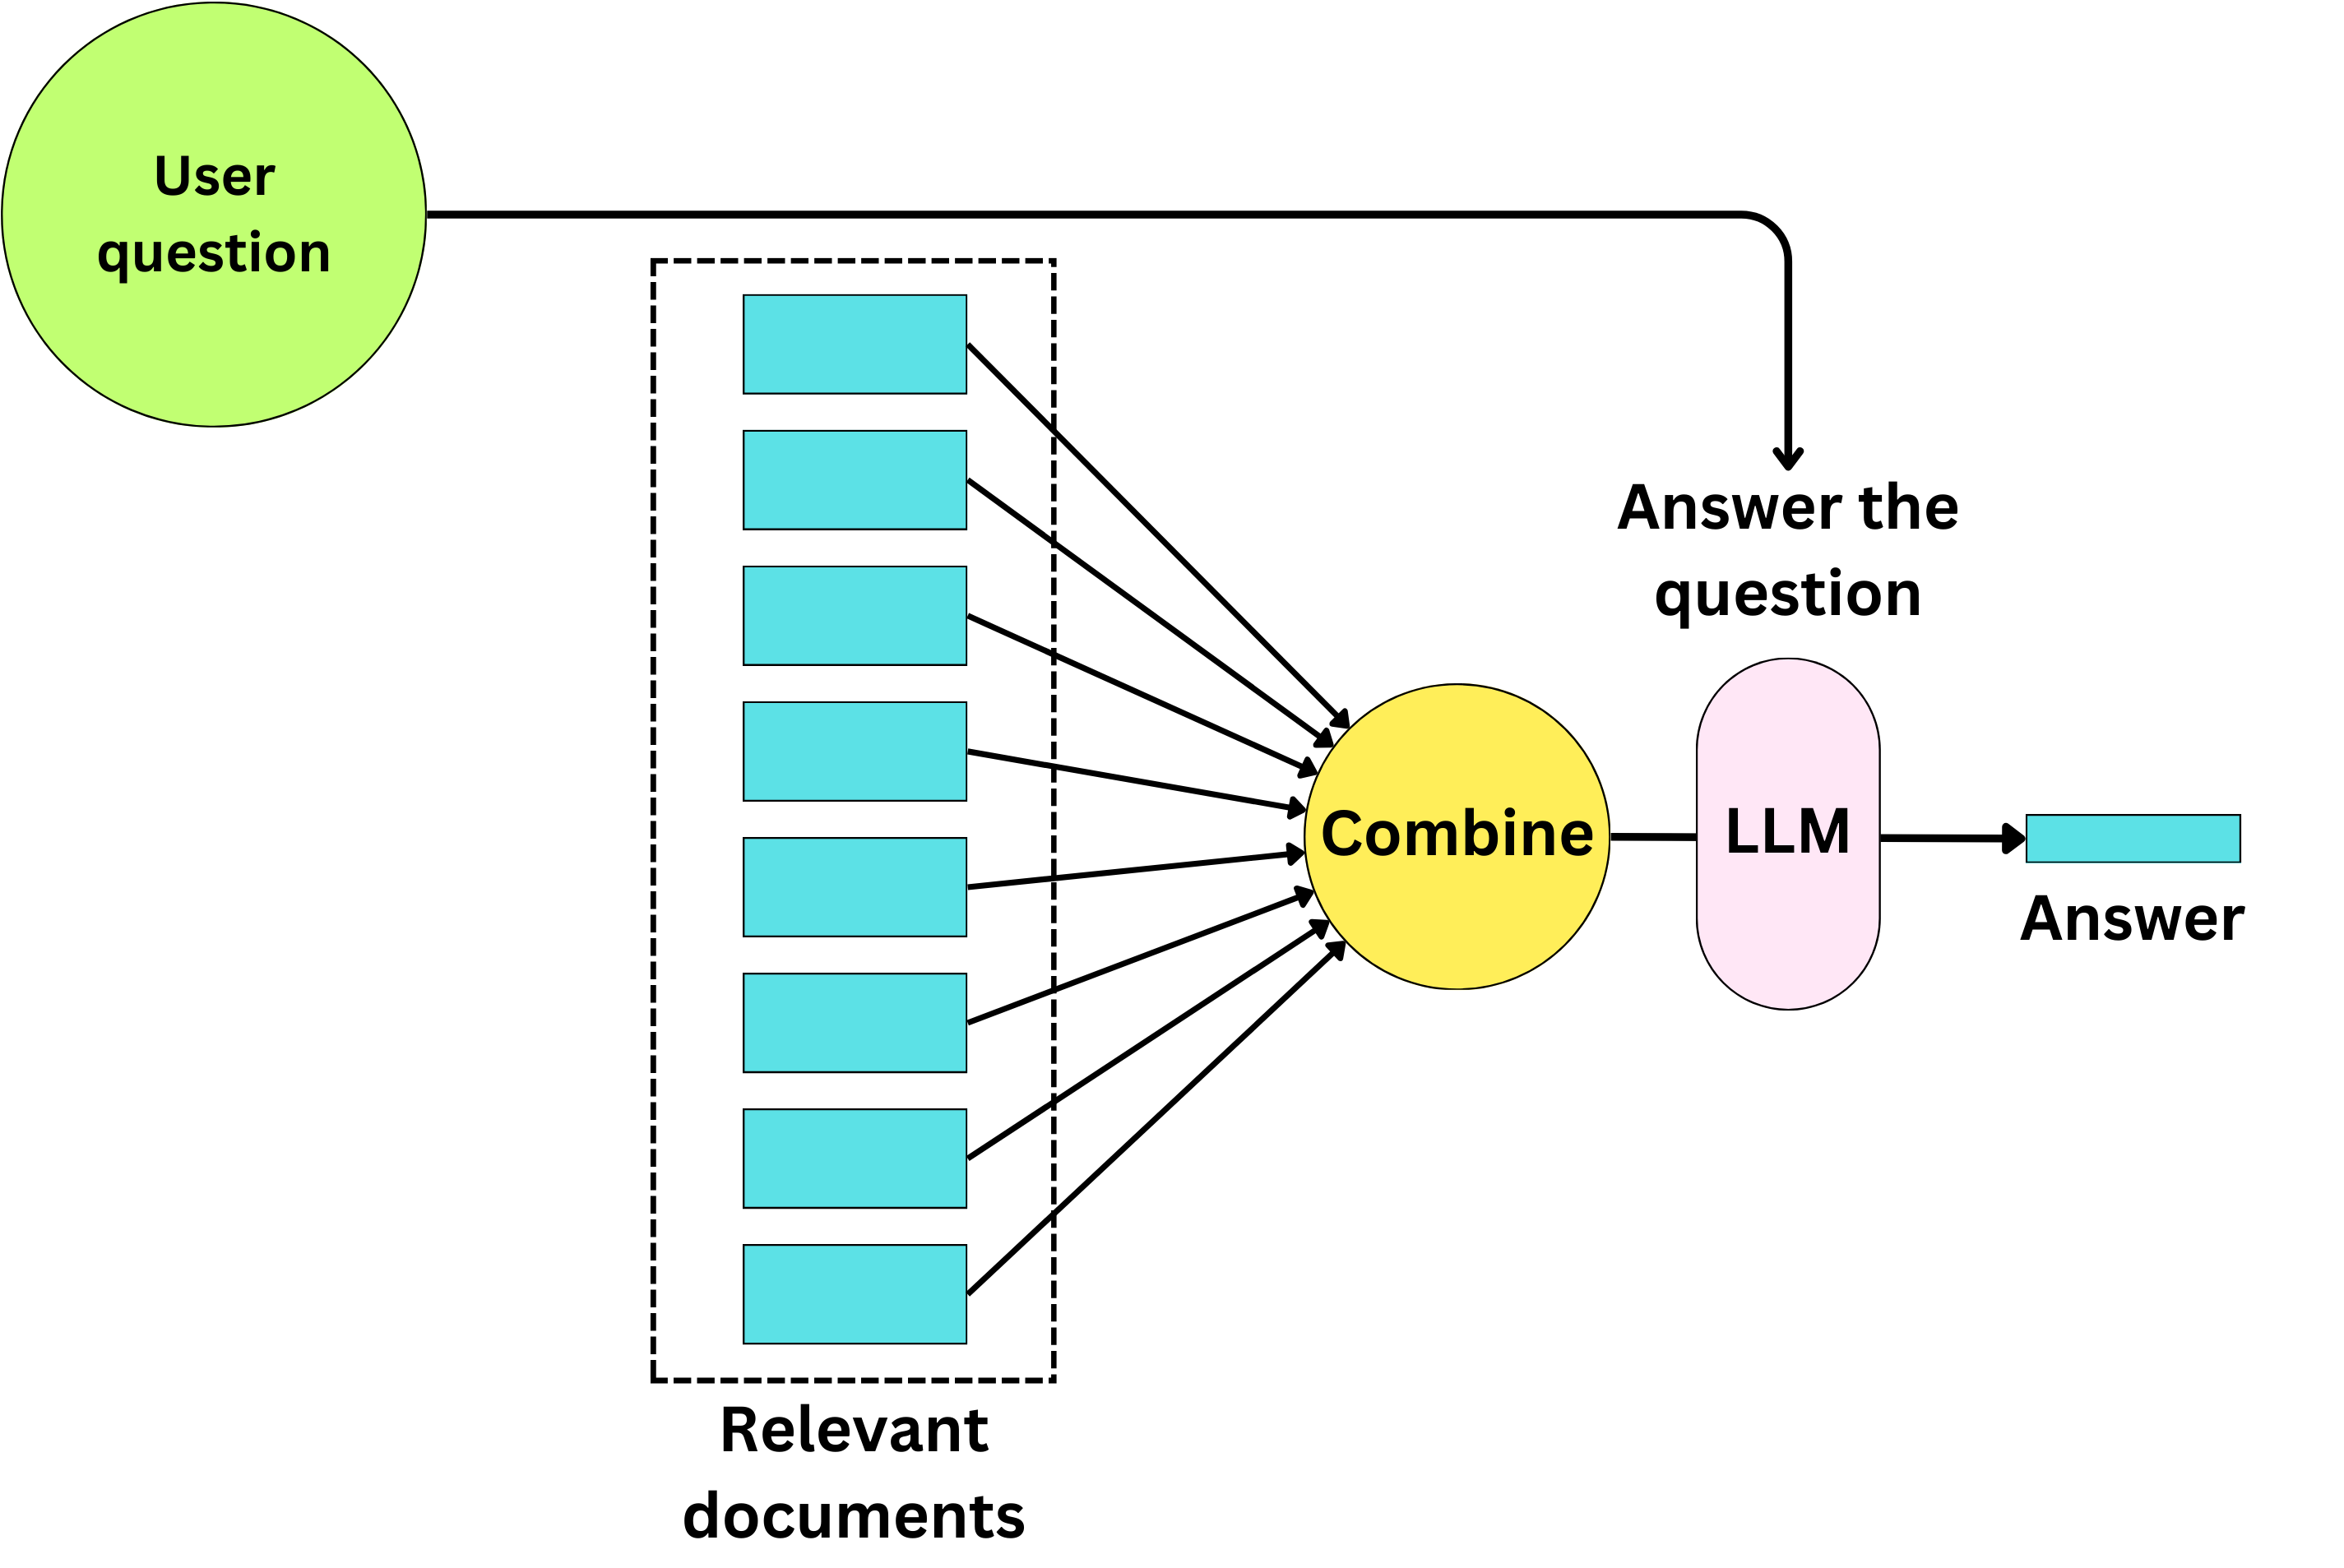

In [39]:
from langchain.chains import RetrievalQA
retrieval = db.as_retriever()
qa = RetrievalQA.from_chain_type(
    llm = mistral_llm,
    retriever = retrieval,
    chain_type = 'stuff'
)
qa.run('what is stuff chain?',callbacks=[StdOutCallbackHandler()])



> Entering new RetrievalQA chain...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

"""**Chains** are easily reusable components linked together.

Chains encode a sequence of calls to components like models, document retrievers,
other Chains, etc., and provide a simple interface to this sequence.

The Chain interface makes it easy to create apps that are:

    - **Stateful:** add Memory to any Chain to give it state,
    - **Observable:** pass Callbacks to a Chain to execute additional functionality,
      like logging, outside the main sequence of component calls,
    - **Composable:** combine Chains with other components, including other Chains.

**Class hierarchy:**

.. code-block::

    Chain --> <name>Chain  # Examples: LLMChain, MapReduceChain, RouterChain
"""

from skeleton_of_thought.chain impor

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(



> Finished chain.

> Finished chain.

> Finished chain.


' "Chains are easily reusable components linked together."'

# Map-Reduce Chain

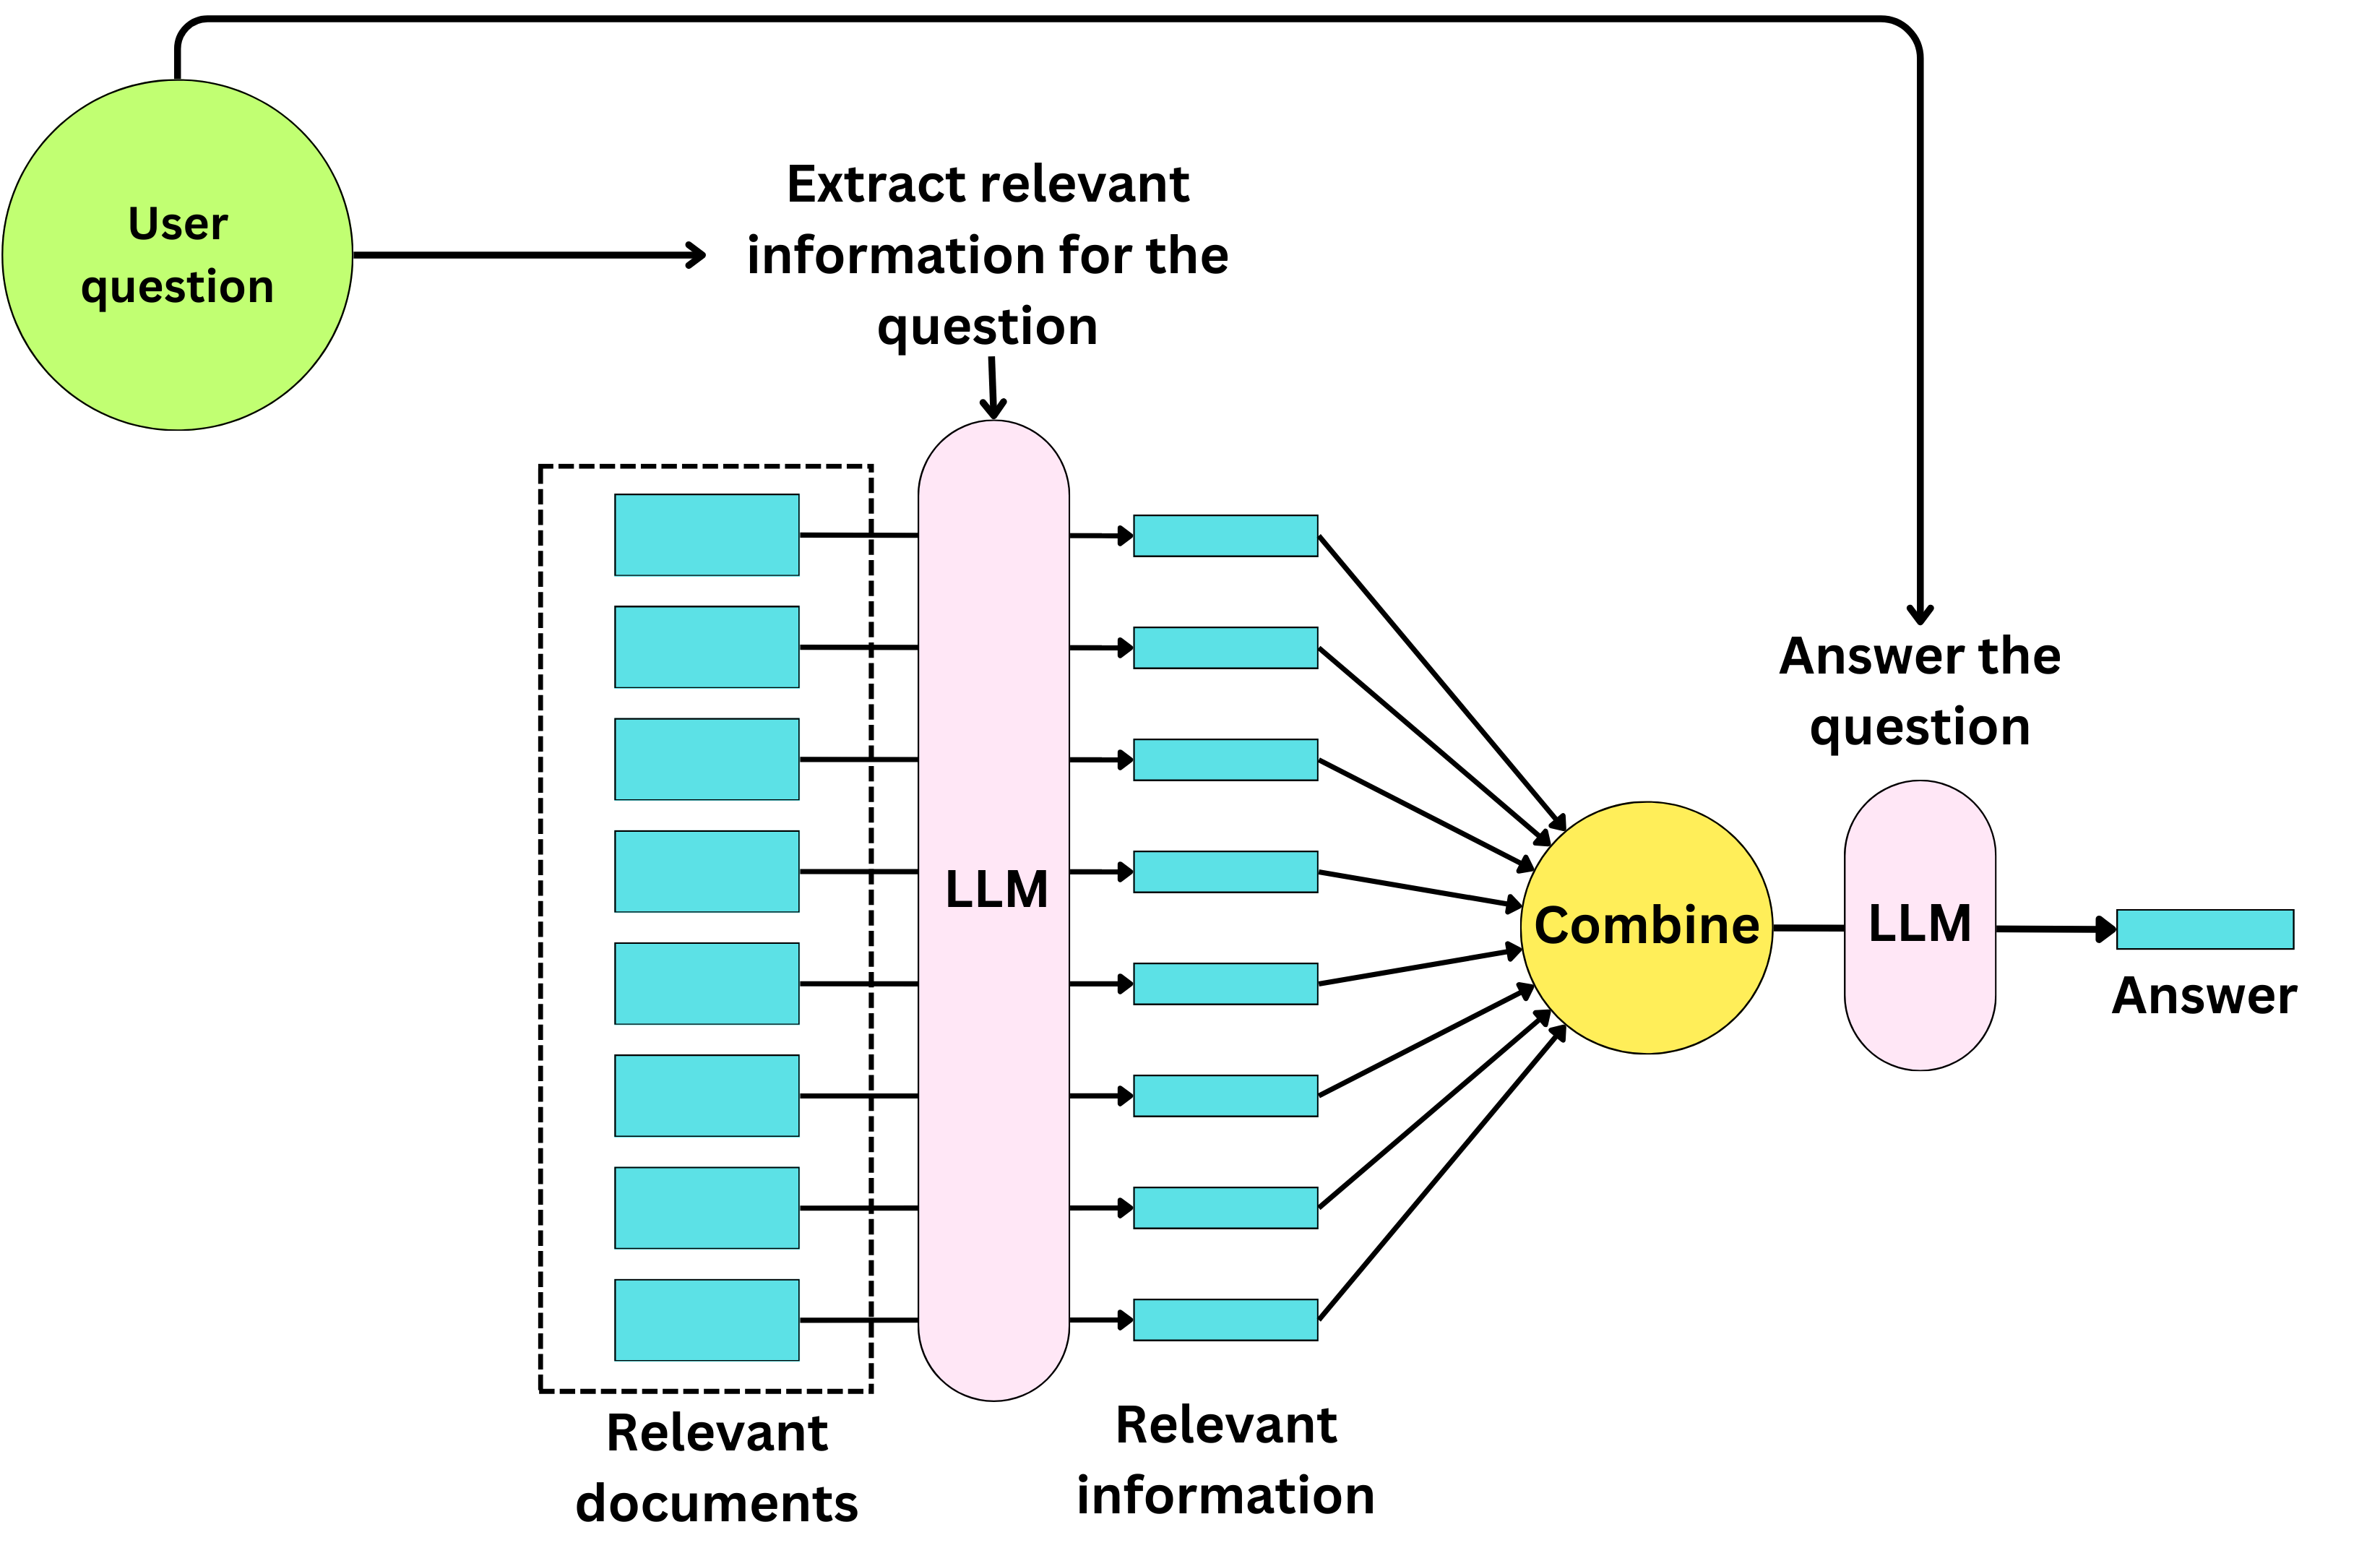

1. get all relevents documents from the VectorDB
2. map all of them to be processed one by one by LLM to extract the useful info from each of them
3. Reduce the outputs from the last phase combined together and input to the LLM with the query to answer the question

In [28]:
retrieval.search_kwargs['distance_metric'] = 'cos'
retrieval.search_kwargs['fetch_k'] = 10
retrieval.search_kwargs['maximal_marginal_relevance']=True
retrieval.search_kwargs['k'] = 10
qa = RetrievalQA.from_chain_type(
    llm = mistral_llm,
    retriever = retrieval,
    chain_type='map_reduce'
)



In [33]:
# qa.run('what is stuff chain?',callbacks=[StdOutCallbackHandler()])

In [31]:
# qa.run('When to use map reduce chain in langchain',callbacks=[StdOutCallbackHandler()])

In [32]:
# qa.run('When to use map Rank in langchain',callbacks=[StdOutCallbackHandler()])

# Refine Chain

![](https://img-c.udemycdn.com/redactor/raw/article_lecture/2023-10-27_04-59-42-a4b9c760d016f1271ceb09089ad60dab.gif)

In [38]:
qa = RetrievalQA.from_chain_type(
    llm = mistral_llm,
    retriever = retrieval,
    chain_type='refine'
)

# qa.run('How to create agents for text style transfer using Langchain',callbacks=[StdOutCallbackHandler()])


# Map Rerank

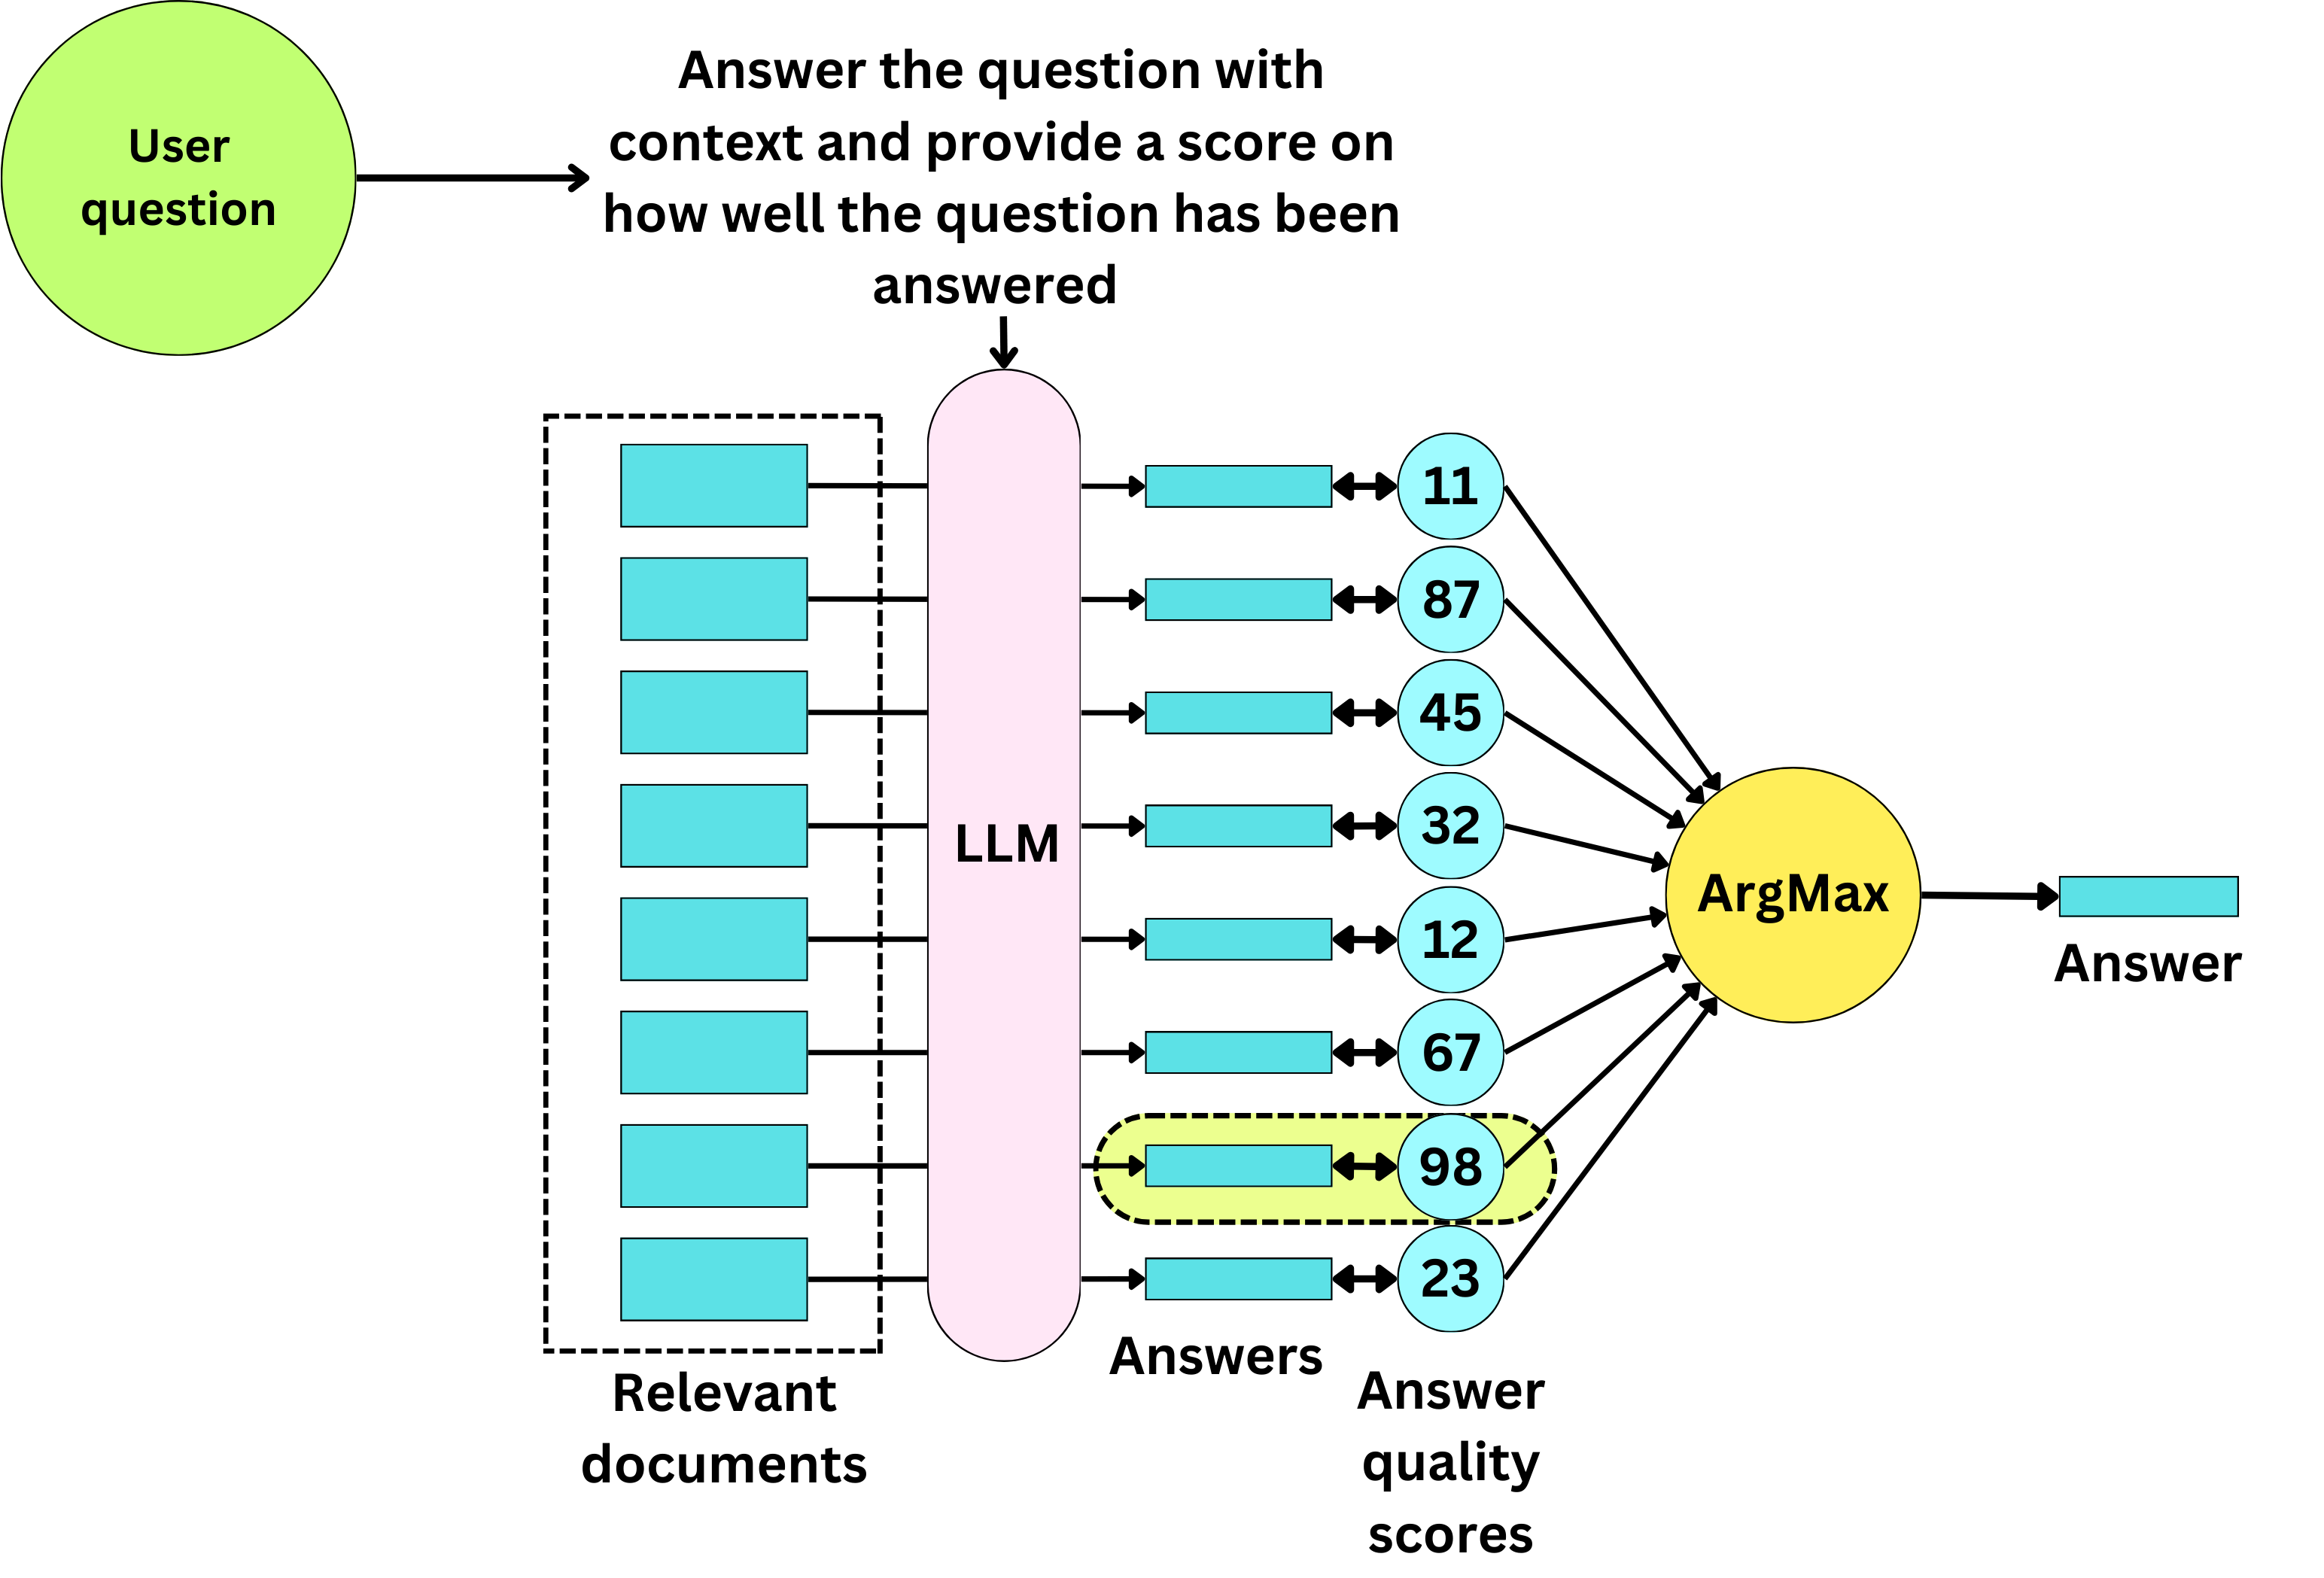

In [37]:
qa = RetrievalQA.from_chain_type(
    llm = mistral_llm,
    retriever = retrieval,
    chain_type='map_rerank'
)

# qa.run('How to create agents for text style transfer using Langchain',callbacks=[StdOutCallbackHandler()])


- This type of chains is good for powerful LLMs that could output the answer in the giving format 